In [1]:
import os
import json
from pickle import dump
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

LANGUAGE_MAPPING = {'A1':1,'A2':2,'B1':3,'B2':4,'C1':5,'C2':6}
DEGREE_MAPPING = {'none':0,'apprenticeship':1,'bachelor':1,'master':2,'doctorate':3}
SENIORITY_MAPPING = {'none':0,'junior':1,'midlevel':2,'senior':3}

## Load Data

In [2]:
project_path = os.getcwd().replace("notebooks","")
with open(f'{project_path}/data/data.json') as f:
    data = json.load(f)

In [3]:
Talent = namedtuple('Talent', ['languages', 'job_roles', 'seniority', 'salary_expectation', 'degree'])
Job = namedtuple('Job', ['languages', 'job_roles', 'seniorities', 'max_salary', 'min_degree'])

talent = [Talent(**d.get('talent')) for d in data]
job = [Job(**d.get('job')) for d in data]
label = [d.get('label') for d in data]

talent_df = pd.DataFrame(talent)
job_df = pd.DataFrame(job)

talent_df = talent_df.rename(columns={'languages':'talent_lang','job_roles':'talent_roles'})
job_df = job_df.rename(columns={'languages':'job_lang'})

In [4]:
df = pd.concat([talent_df, job_df],axis=1)
df['label'] = label

## Feature Extraction

In [5]:
def extract_lang_skills(x,mh_param=True):
    if mh_param:
        return {i.get('title'):LANGUAGE_MAPPING[i.get('rating')] for i in x if i.get('must_have')}
    return {i.get('title'):LANGUAGE_MAPPING[i.get('rating')] for i in x}

def meets_lang_requirements(talent_lang, job_lang):
    for l in job_lang:
        if job_lang.get(l) > talent_lang.get(l,0):
            return 0
    return 1

df['talent_lang'] = df.apply(lambda x: extract_lang_skills(x.talent_lang, False), axis=1)
df['job_lang_mh'] = df.apply(lambda x: extract_lang_skills(x.job_lang), axis=1)
#we determine whether the language requirements of the job are satisfied by the talent
df['lang_reqs_satisfied'] = df.apply(lambda x: meets_lang_requirements(x.talent_lang,x.job_lang_mh), axis=1)

In [6]:
#we create a feature to calculate the difference of degree of talent vs of min degree required for the job
df['degree_diff'] = df.apply(lambda x: DEGREE_MAPPING[x.get('degree')]-DEGREE_MAPPING[x.get('min_degree')], axis=1)

def get_seniority_diff(talent_s, job_s):
    job_s = min([SENIORITY_MAPPING.get(i) for i in job_s])
    return SENIORITY_MAPPING.get(talent_s) - job_s

#similarly we create a feature to calculate the difference of seniority of the talent vs the min seniority requested on on the job
df['seniority_diff'] = df.apply(lambda x: get_seniority_diff(x.seniority, x.seniorities), axis=1)

#for salary we calculate the difference
df['salary_diff'] = df.apply(lambda x: x.max_salary-x.salary_expectation, axis=1)

#for roles we calculate the length of the list intersection between job and talent roles
def get_intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

df['job_intersection'] = df.apply(lambda x: get_intersection(x.talent_roles,x.job_roles),axis=1)
df['job_intersection_len'] = df.apply(lambda x: len(x.job_intersection),axis=1)

## Feature Selection & Modelling

In [7]:
print(f'number of data samples:{len(df)}, with {sum(df.label)} true and {len(df[~df.label])} false samples')

number of data samples:2000, with 1000 true and 1000 false samples


In [8]:
features = ['lang_reqs_satisfied','degree_diff','seniority_diff','salary_diff','job_intersection_len']
X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df.label,                                                
                                                    test_size=0.25,
                                                    random_state=0)

### Knn classifier

In [9]:
knn = KNeighborsClassifier()
scaler = StandardScaler()

X_train_knn = scaler.fit_transform(X_train)
X_test_knn = scaler.transform(X_test)

knn.fit(X_train_knn, y_train)

y_pred = knn.predict(X_test_knn)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.986


array([[240,   6],
       [  1, 253]])

### Randomforest classifier

In [10]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.988


array([[245,   1],
       [  5, 249]])

In [11]:
with open(f'{project_path}/models/rf_model.pkl', 'wb') as model_file:
    dump(rf, model_file)

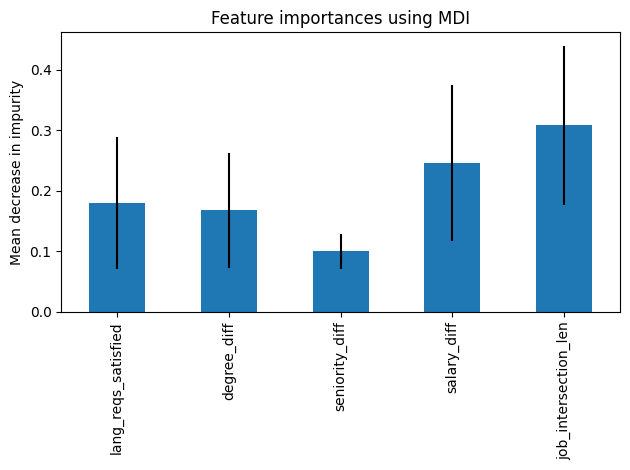

In [12]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(rf.feature_importances_, 
                               index=rf.feature_names_in_)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Summary points

* With the data that we were provided, related to candidate skills and employee requirements, we were able create features that could be used for training a model.
* We experimented with classifier models since they can be used to calculate a matching score (probability of belonging to class True) and use the limit of 0.5, since we have a balanced dataset to assign the 'true' or 'false' label.
* We selected a knn classifier as a baseline and showed that randomforest can be used as an improvement, which is the model that we save for future use.
* For randomforest we can use the MDI plot to review feature importance (the higher the bar the higher the importance of the corresponding feature).